In [41]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Load dataset
df = pd.read_csv("spam.csv", encoding="latin-1")[['v1', 'v2']] 
df.columns = ['label', 'text']  # Rename
df.dropna(subset=['label', 'text'], inplace=True)  # Drop rows where label or text is missing


In [43]:
# Map labels to 0 and 1
df['label_bin'] = df['label'].map({'ham': 0, 'spam': 1})

# Droping rows where label_bin is Null
df = df.dropna(subset=['label_bin'])
print(df.isna().sum())
print(df['label_bin'].value_counts())


label        0
text         0
label_bin    0
dtype: int64
label_bin
0.0    4825
1.0     747
Name: count, dtype: int64


In [45]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label_bin'], test_size=0.2, random_state=42)

# TF-IDF Vectorization
tfidf = TfidfVectorizer(stop_words='english', max_df=0.9)
Xtr = tfidf.fit_transform(X_train)
Xte = tfidf.transform(X_test)


In [47]:
# Logistic Regression with GridSearchCV
lr_params = {'C': [0.1, 1, 10]}
lr = GridSearchCV(LogisticRegression(max_iter=1000), lr_params, cv=3, scoring='f1', n_jobs=-1)
lr.fit(Xtr, y_train)
lr_best = lr.best_estimator_
y_pred_lr = lr_best.predict(Xte)

# Random Forest with GridSearchCV
rf_params = {'n_estimators': [50, 100], 'max_depth': [None, 10]}
rf = GridSearchCV(RandomForestClassifier(random_state=42), rf_params, cv=3, scoring='f1', n_jobs=-1)
rf.fit(Xtr, y_train)
rf_best = rf.best_estimator_
y_pred_rf = rf_best.predict(Xte)
y_prob_rf = rf_best.predict_proba(Xte)[:, 1]

def eval_metrics(y_true, y_pred, model_name):
    print(f"\n {model_name}")
    print("Accuracy :", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred))
    print("Recall   :", recall_score(y_true, y_pred))
    print("F1-score :", f1_score(y_true, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))


In [48]:
# Evaluate both models
eval_metrics(y_test, y_pred_lr, "Logistic Regression (tuned)")
eval_metrics(y_test, y_pred_rf, "Random Forest (tuned)")

cm_lr = confusion_matrix(y_test, y_pred_lr)



 Logistic Regression (tuned)
Accuracy : 0.9757847533632287
Precision: 0.9624060150375939
Recall   : 0.8533333333333334
F1-score : 0.9045936395759717
Confusion Matrix:
 [[960   5]
 [ 22 128]]

 Random Forest (tuned)
Accuracy : 0.9748878923766816
Precision: 0.9841269841269841
Recall   : 0.8266666666666667
F1-score : 0.8985507246376812
Confusion Matrix:
 [[963   2]
 [ 26 124]]


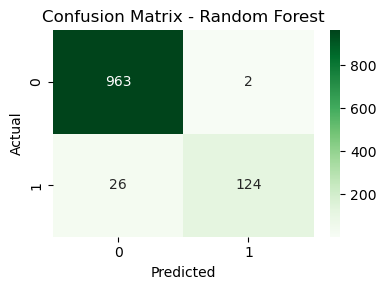

C:\Users\family\AppData\Local\Temp\ipykernel_23376\3262336089.py:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', color="red")


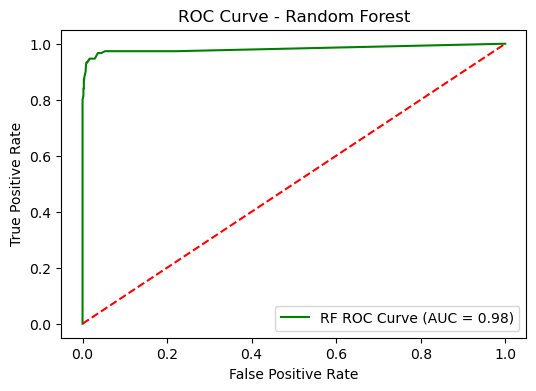

In [49]:
# confusion matrix
cm_rf = confusion_matrix(y_true, y_pred_rf)

plt.figure(figsize=(4, 3))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens')
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# ROC Curve for Random Forest
fpr, tpr, _ = roc_curve(y_test, y_prob_rf)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'RF ROC Curve (AUC = {auc(fpr, tpr):.2f})',color ="green")
plt.plot([0, 1], [0, 1], 'k--', color="red")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Random Forest")
plt.legend()
plt.show()

feature_importances = pd.Series(rf_best.feature_importances_, index=tfidf.get_feature_names_out())
top_15 = feature_importances.sort_values(ascending=False).head(15)

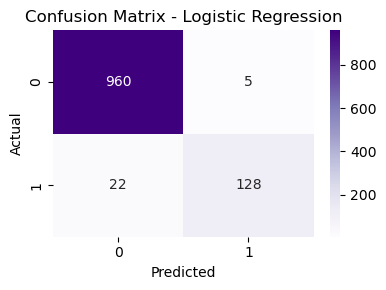

In [50]:
# confusion matrix
plt.figure(figsize=(4, 3))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Purples')
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

y_true = y_test  # true labels
y_pred_rf = rf_best.predict(Xte)  # predicted by Random Forest


C:\Users\family\AppData\Local\Temp\ipykernel_23376\735577043.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_15.values, y=top_15.index, palette='viridis')


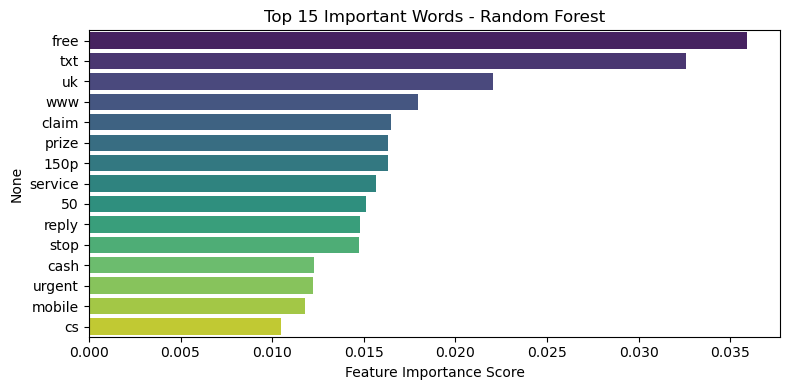

In [51]:
# top 15 important words - random foresting
plt.figure(figsize=(8, 4))
sns.barplot(x=top_15.values, y=top_15.index, palette='viridis')
plt.title("Top 15 Important Words - Random Forest")
plt.xlabel("Feature Importance Score")
plt.tight_layout()
plt.show()


In [52]:
# Feature Importance (Top 15 terms)
import numpy as np
feat_imp = pd.Series(rf_best.feature_importances_, index=tfidf.get_feature_names_out())
top_feat = feat_imp.sort_values(ascending=False).head(15)
print("\nTop 15 Important Features (Random Forest):")
print(top_feat)


Top 15 Important Features (Random Forest):
free       0.035923
txt        0.032605
uk         0.022035
www        0.017965
claim      0.016468
prize      0.016317
150p       0.016311
service    0.015694
50         0.015143
reply      0.014795
stop       0.014721
cash       0.012260
urgent     0.012212
mobile     0.011805
cs         0.010497
dtype: float64
